# Magnus approximation and robustness objective demo

This demo walks through some example usages of the Magnus expansion computation tools in the Qiskit Dynamics `perturbation` module. In particular, using a model of a single transmon system, we demonstrate: 

- How to use the Magnus expansion to perturbatively approximate the fidelity of a control sequence in a region of model parameter space.
- How the perturbation expansion computation/management tools in Qiskit Dynamics can be used to construct an arbitrary order multivariable robustness objective.

In each section, we:
1. Build the matrices for a model of a transmon system for a given truncation dimension.
2. Build a sample control signal parameterization that is bounded and smooth.
3. Build a gate fidelity function for an $X$ gate on the first two levels of the transmon model.
4. For a given list of model perturbations, plot how the fidelity changes with the magnitude of the perturbation, and investigate how well the Magnus expansion approximates this curve to various orders.
5. Build a robustness objective that can use arbitrary order Magnus expansion data, utilizing the truncated power-series computation and manipulation functionality in the `perturbation` module of Qiskit Dynamics.

In [1]:
import numpy as np
import jax.numpy as jnp

from qiskit_dynamics.array import Array

# configure jax to use 64 bit mode
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'gpu')


# set default backend
Array.set_default_backend('jax')

Set plotting defaults. Making plots and fonts large for higher resolution figures in paper.

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = np.array(plt.rcParamsDefault["figure.figsize"])*2 # double default size
plt.rcParams.update({'font.size': 20}) # double font size (default is 10)

## 1. Build the model components

Here we build operators and set parameters used to specify the transmon model:

$$H(t) = 2 \pi \nu N + \pi \alpha N(N - I) + \frac{\pi}{3} \beta N(N-I)(N-2I) + s(t) \times 2 \pi r (a + a^\dagger),$$

where
- $\nu$ is the qubit frequency and $N$ is the number operator,
- $\alpha$ is the anharmonicity,
- $\beta$ sets the spacing to the 4th level, and
- $r$ is the drive strength, $s(t)$ is the control signal, and $a$ is the annihilation operator.

In [3]:
dim = 5 # truncation dimension

# truncated annihilation, creation, and number operators
a = jnp.diag(np.sqrt(np.arange(1, dim, dtype=complex)), -1)
adag = a.conj().transpose()
numb = jnp.diag(np.arange(dim, dtype=complex))
ident = np.eye(dim, dtype=complex)

# truncated oscillator X and Y
osc_X = a + adag
osc_Y = 1j*(a-adag)

# projection onto levels above the first two
ones = np.ones(dim, dtype=complex)
ones[0:2] = np.array([0., 0.])
P = np.diag(ones)

# model parameters - work in units of GHz/ns
v = 5.0
anharm = -0.33
beta = -0.015
r = 0.02

# 2. Construct control signal parameterization

Here we construct a parameterized on-resonance control signal:

$$p \mapsto s(t) = Re[f(t)e^{i 2 \pi \nu t}],$$

where $f(t)$ is the parameterized envelope. To get a parameterized control sequence that is both bounded and smooth:
- Take a linear combination of discretized Chebyshev polynomials (given as arrays), with the parameters $p$ being the coefficients.
- Given the linear combination, pass each entry through a differentiable mapping taking $\mathbb{R} \rightarrow [-1, 1]$ (to bound the envelope).
- Apply a filter to smooth the samples.

For this, we take $p$ as a shape $(2, k)$ array, where $k$ is the number of Chebyshev polynomials used, and there are two rows as we construct both a real and complex part.

In [4]:
from qiskit_dynamics import DiscreteSignal
from discrete_signals import get_param_to_signal

# choose the size of the cheb basis
cheb_order = 8

# choose # steps of the signal
N = 50

# Construct the parameterization given the parameters
param_to_signal = get_param_to_signal(cheb_order, N)
sample_dt = 0.125

# total time of pulse
T = sample_dt * len(param_to_signal(np.random.rand(2, cheb_order + 1)))

Plot for some random parameters.

In [5]:
test = DiscreteSignal(samples=param_to_signal(10. * np.random.rand(2, cheb_order + 1)),
                      dt=sample_dt,
                      carrier_freq=v)

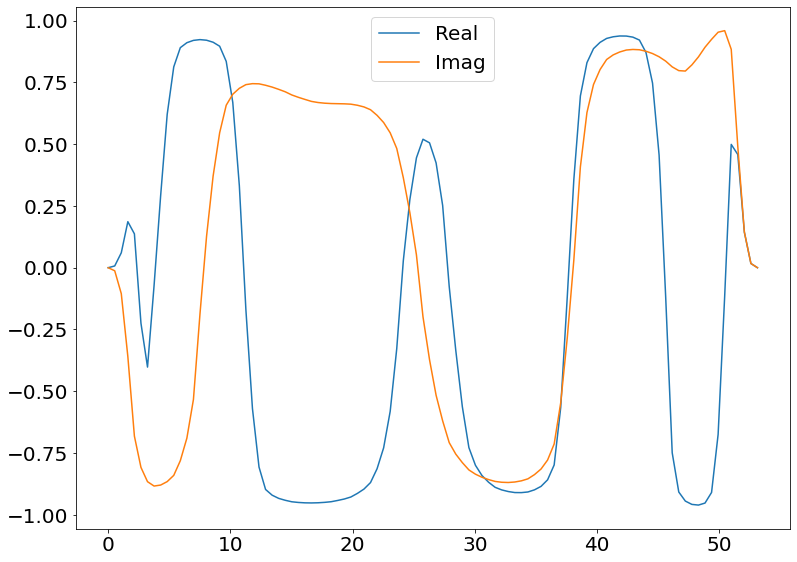

In [6]:
test.draw(0, T, n=100, function='envelope')

# 3. Construct fidelity objective

Given a unitary $V$ generated by one of the above control sequences and the transmon model, construct a function computing the fidelity with repect to an $X$ gate on the first two levels:

$$f(V) = \frac{|\langle X, V|_2 \rangle|^2}{4},$$

where $V|_2$ is the restriction to the first two levels.

In [7]:
X = Array([[0., 1.], [1., 0.]])

def fidelity(V):
    V = Array(V)
    return np.abs((X * V[0:2, 0:2]).sum())**2 / 4

# 4. Magnus expansion approximations to fidelity

Here we consider the following list of perturbations to the model of our transmon:

**Need to fill these in once finalized - I think what we have is good but could still be tweaked**

For a given perturbation, we plot the fidelity of a pulse as a function of the perturbation coefficient, along with an approximation of the fidelity with respect to this perturbation generated using various orders of the Magnus expansion. For a given truncated Magnus expansion, $\Omega(c)$, computed using the `solve_lmde_perturbation` function, we construct an `ArrayPolynomial` for evaluating $\Omega(c)$, and use this to compute an approximate unitary:

$$V(c) \approx V(0)e^{\Omega(c)},$$

where $\Omega(c)$ is computed in the toggling frame. 

In [8]:
from qiskit_dynamics import Solver, DiscreteSignal, RotatingFrame
from qiskit_dynamics.perturbation import solve_lmde_perturbation, ArrayPolynomial
from qiskit_dynamics.array import Array
from jax import jit

from functools import partial
from jax import jit
from jax.scipy.linalg import expm as jexpm

static_hamiltonian = (
    2 * np.pi * v * numb + 
    np.pi * anharm * numb * (numb - ident) + 
    (np.pi/3) * beta * numb * (numb - ident) * (numb - 2 * ident)
)
drive_hamiltonian = 2 * np.pi * r * osc_X

perturb1 = 2 * np.pi * v * numb
perturb2 = np.pi * anharm * numb * (numb - ident)
perturb3 = 2 * np.pi * r * osc_X
perturb4 = 2 * np.pi * r * osc_X
perturb5 = (np.pi / 3) * beta * numb * (numb - ident) * (numb - 2 * ident)
perturb6 = 2 * np.pi * r * (P @ osc_X @ P)

hamiltonian_operators = [
    drive_hamiltonian,
    perturb1,
    perturb2,
    perturb3,
    perturb4,
    perturb5,
    perturb6
]

solver = Solver(
    static_hamiltonian=static_hamiltonian,
    hamiltonian_operators=hamiltonian_operators,
    rotating_frame=np.diag(static_hamiltonian)
)

def ode_infidelity(control_params, model_params):
    # construct s(b, t)
    samples = param_to_signal(control_params)
    control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
    
    # extract model parameters and set up solver coefficients
    c1, c2, c3, c4, c5, c6 = model_params

    signals = [
        control_signal,
        Array(c1),
        Array(c2),
        control_signal * Array(c3),
        (control_signal * control_signal) * Array(c4),
        Array(c5),
        control_signal * Array(c6)
    ]
    
    results = solver.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        signals=signals,
        atol=1e-14, 
        rtol=1e-14,
        method='jax_odeint'
    )
    
    # return infidelity
    return 1. - fidelity(results.y[-1]).data

rotating_frame = solver.model.rotating_frame

def compute_1d_perturbation_comparison(
    control_params, 
    model_params_dir, 
    perturbation, 
    perturb_vals,
    max_magnus_order=5
):
    """
    Args:
        control_params for params to signal
        model_params_dir for 1d direction in model parameter space
        perturbation is the function computing the perturbation in the lab frame
        perturb_vals is the list of values to plot over
        max_magnus_order is the maximum magnus order to compute up to
    """
    
    # jit function for computing ode fidelity
    ode_func = jit(lambda x: ode_infidelity(control_params, x * model_params_dir))
    
    # compute perturbation terms
    samples = param_to_signal(control_params)
    control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
    
    def generator(t):
        op = control_signal(t) * (-1j * drive_hamiltonian)
        return rotating_frame.operator_into_frame(t, op)
    
    def perturb_in_frame(t):
        op = perturbation(t)
        return rotating_frame.operator_into_frame(t, op)
    
    results = solve_lmde_perturbation(
        perturbations=[perturb_in_frame],
        t_span=[0, T],
        expansion_method='magnus',
        expansion_order=max_magnus_order,
        generator=generator,
        integration_method='jax_odeint',
        rtol=1e-14,
        atol=1e-14
    )
    term_labels = results.perturbation_data.labels
    perturbation_terms = results.perturbation_data.data
    
    # construct magnus expansions for each order from results
    magnus_expansions = []
    for order in range(1, max_magnus_order + 1):
        n_terms = list(map(lambda x: len(x) <= order, term_labels)).count(True)
        magnus_expansion = ArrayPolynomial(
            array_coefficients=perturbation_terms[:n_terms, -1],
            monomial_labels=term_labels[:n_terms]
        )
        magnus_expansions.append(magnus_expansion)
    
    U = results.y[-1]
    
    # get the 1st to 5th order approximate error rates using the Magnus terms
    @partial(jit, static_argnums=(1,))
    def magnus_infidelity(perturb_val, order):

        coeffs = jnp.array([perturb_val])

        U_approx = U @ jexpm(magnus_expansions[order - 1](coeffs).data)

        return 1. - fidelity(U_approx).data
    
    ode_vals = []
    magnus_vals = [[] for _ in range(max_magnus_order)]
    for val in perturb_vals:
        ode_vals.append(ode_func(val))
        
        for order, magnus_val in enumerate(magnus_vals):
            magnus_val.append(magnus_infidelity(val, order + 1))
    
    return ode_vals, magnus_vals

Get random control parameters.

In [9]:
# randomized control params
#rand_control_params = 10. * np.random.rand(2, cheb_order + 1)

# parameters used for paper plotting
rand_control_params = np.array(
    [[2.97235791, 6.7224981 , 7.10389933, 6.28308916, 3.3141785,
      3.18516454, 0.14489385, 0.73061711, 4.95786088],
     [4.36631334, 7.39274027, 4.92186901, 4.63936992, 0.25425063,
      2.48857663, 7.49995631, 0.63013977, 8.56971277]]
)

# set max order to use
max_magnus_order = 9

## 4.1 1st perturbation

Text(0, 0.5, 'Infidelity')

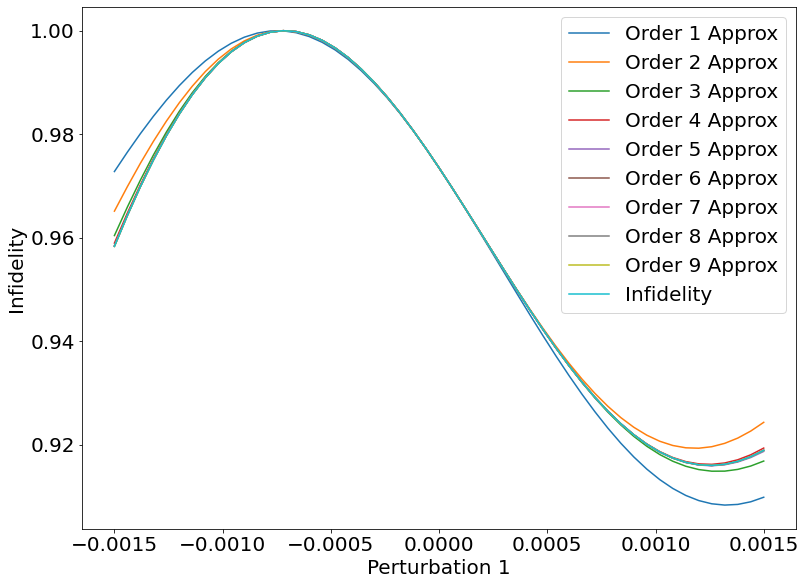

In [10]:
perturb1_vals = jnp.linspace(-0.0015, 0.0015, 51)

perturb1_results = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([1., 0., 0., 0., 0., 0.]), 
    perturbation = lambda t: -1j * perturb1, 
    perturb_vals=perturb1_vals,
    max_magnus_order=max_magnus_order
)

for k in range(max_magnus_order):
    plt.plot(perturb1_vals, perturb1_results[1][k],label=f'Order {k+1} Approx')

plt.plot(perturb1_vals, perturb1_results[0], label='Infidelity')
plt.legend()
plt.xlabel('Perturbation 1')
plt.ylabel('Infidelity')

Text(0, 0.5, 'Infidelity error')

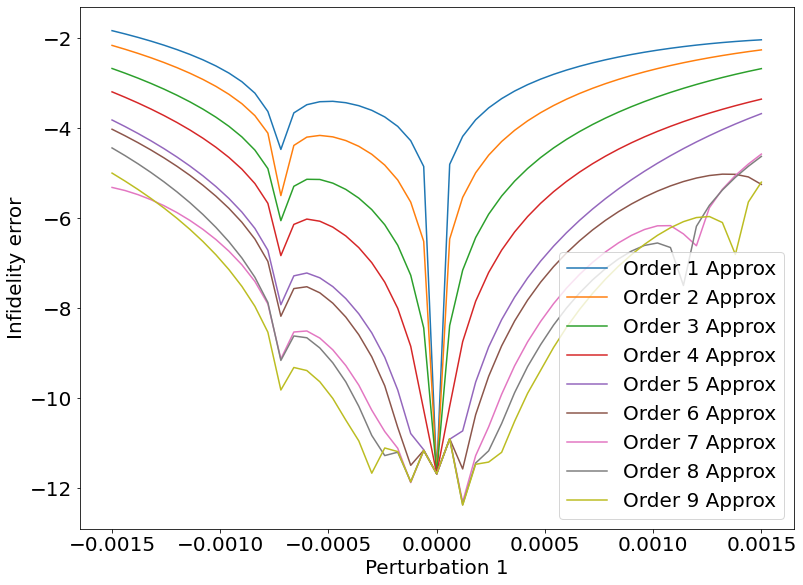

In [11]:
# error plot
errors1 = [
    np.log10(np.abs(np.array(perturb1_results[1][k]) - np.array(perturb1_results[0]))) for k in range(max_magnus_order)
]

for k in range(max_magnus_order):
    plt.plot(perturb1_vals,errors1[k],label=f'Order {k+1} Approx')

plt.legend()
plt.xlabel('Perturbation 1')
plt.ylabel('Infidelity error')

## 4.2 2nd perturbation

Text(0, 0.5, 'Infidelity')

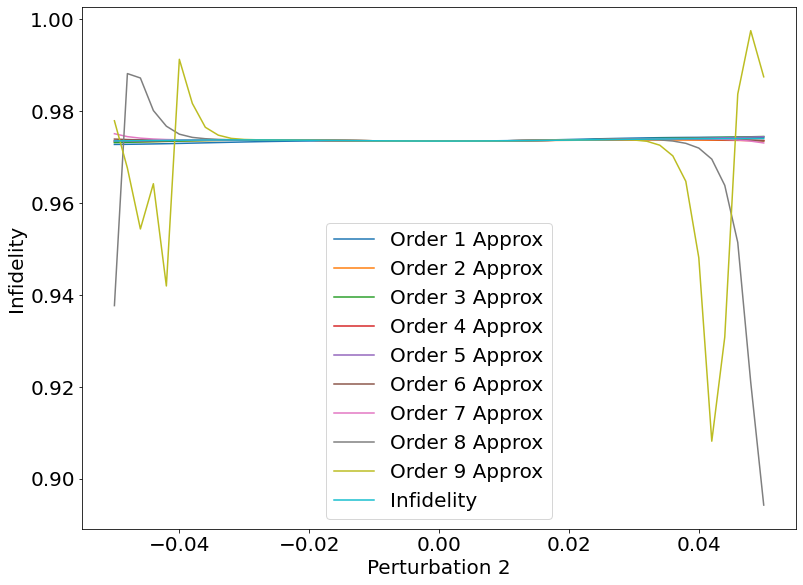

In [12]:
perturb2_vals = jnp.linspace(-0.05, 0.05, 51)

perturb2_results = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([0., 1., 0., 0., 0., 0.]), 
    perturbation = lambda t: -1j * perturb2, 
    perturb_vals=perturb2_vals,
    max_magnus_order=max_magnus_order
)

for k in range(max_magnus_order):
    plt.plot(perturb2_vals, perturb2_results[1][k],label=f'Order {k+1} Approx')

plt.plot(perturb2_vals, perturb2_results[0], label='Infidelity')
plt.legend()
plt.xlabel('Perturbation 2')
plt.ylabel('Infidelity')

Text(0, 0.5, 'Infidelity error')

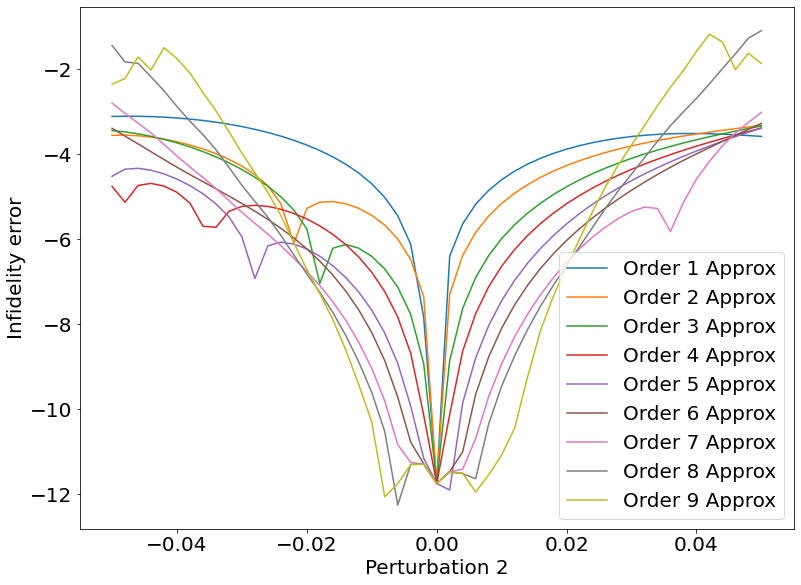

In [13]:
# error plot
errors2 = [
    np.log10(np.abs(np.array(perturb2_results[1][k]) - np.array(perturb2_results[0]))) for k in range(max_magnus_order)
]

for k in range(max_magnus_order):
    plt.plot(perturb2_vals,errors2[k],label=f'Order {k+1} Approx')

plt.legend()
plt.xlabel('Perturbation 2')
plt.ylabel('Infidelity error')

## 4.3 3rd perturbation

The expansions here are highly accurate, interestingly.

Text(0, 0.5, 'Infidelity')

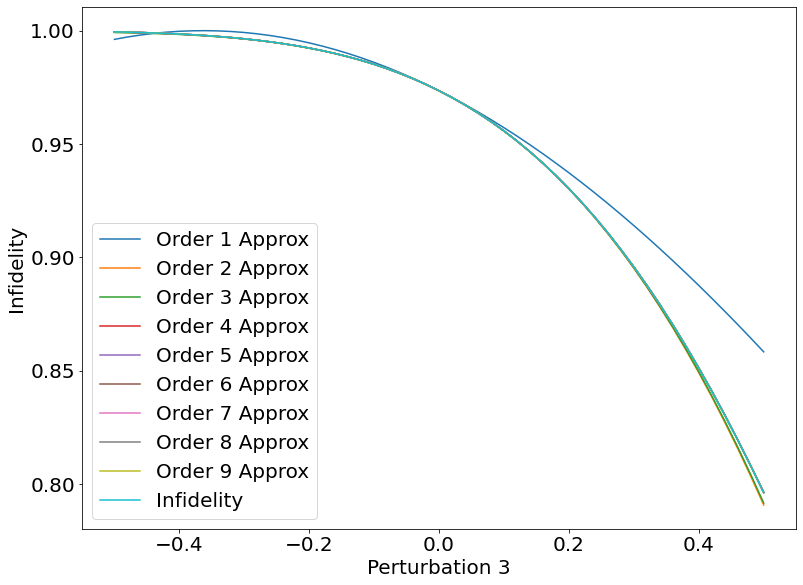

In [14]:
perturb3_vals = jnp.linspace(-0.5, 0.5, 51)

# compute perturbation terms
samples = param_to_signal(rand_control_params)
control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)

perturb3_results = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([0., 0., 1., 0., 0., 0.]), 
    perturbation = lambda t: -1j * control_signal(t) * drive_hamiltonian, 
    perturb_vals=perturb3_vals,
    max_magnus_order=max_magnus_order
)

for k in range(max_magnus_order):
    plt.plot(perturb3_vals, perturb3_results[1][k],label=f'Order {k+1} Approx')
    
plt.plot(perturb3_vals, perturb3_results[0], label='Infidelity')
plt.legend()
plt.xlabel('Perturbation 3')
plt.ylabel('Infidelity')

Text(0, 0.5, 'Infidelity error')

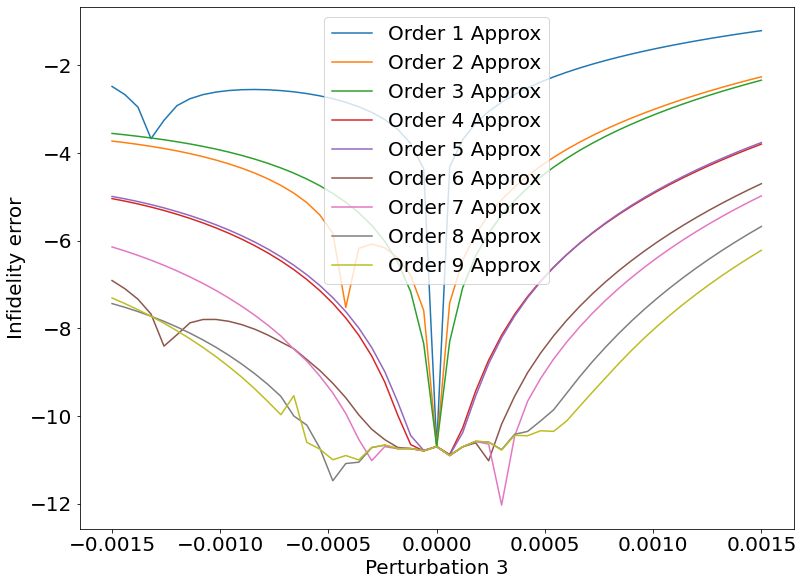

In [15]:
# error plot
errors3 = [
    np.log10(np.abs(np.array(perturb3_results[1][k]) - np.array(perturb3_results[0]))) for k in range(max_magnus_order)
]

for k in range(max_magnus_order):
    plt.plot(perturb1_vals,errors3[k],label=f'Order {k+1} Approx')

plt.legend()
plt.xlabel('Perturbation 3')
plt.ylabel('Infidelity error')

## 4.4 4th perturbation

Text(0, 0.5, 'Infidelity')

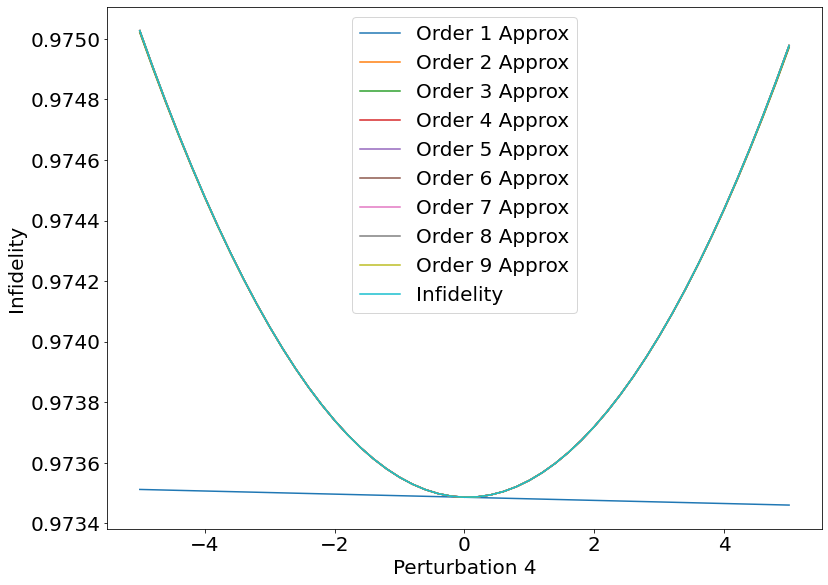

In [16]:
perturb4_vals = jnp.linspace(-5., 5., 51)

# compute perturbation terms
samples = param_to_signal(rand_control_params)
control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
control_signal2 = control_signal * control_signal

perturb4_results = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([0., 0., 0., 1., 0., 0.]), 
    perturbation = lambda t: -1j * control_signal2(t) * drive_hamiltonian, 
    perturb_vals=perturb4_vals,
    max_magnus_order=max_magnus_order
)

for k in range(max_magnus_order):
    plt.plot(perturb4_vals, perturb4_results[1][k],label=f'Order {k+1} Approx')

plt.plot(perturb4_vals, perturb4_results[0], label='Infidelity')
plt.legend()
plt.xlabel('Perturbation 4')
plt.ylabel('Infidelity')

Text(0, 0.5, 'Infidelity error')

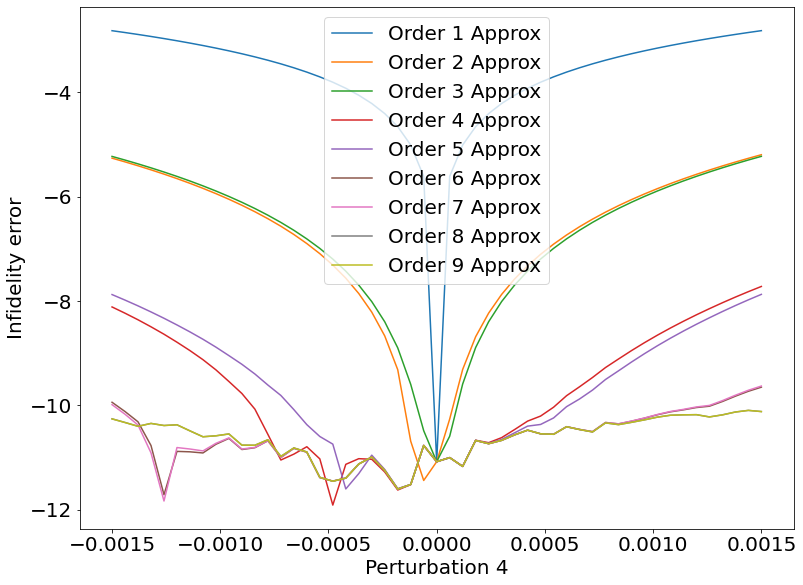

In [17]:
# error plot
errors4 = [
    np.log10(np.abs(np.array(perturb4_results[1][k]) - np.array(perturb4_results[0]))) for k in range(max_magnus_order)
]

for k in range(max_magnus_order):
    plt.plot(perturb1_vals,errors4[k],label=f'Order {k+1} Approx')

plt.legend()
plt.xlabel('Perturbation 4')
plt.ylabel('Infidelity error')

## 4.5 5th perturbation

This one seems to mainly be limited by numerical error.

Text(0, 0.5, 'Infidelity')

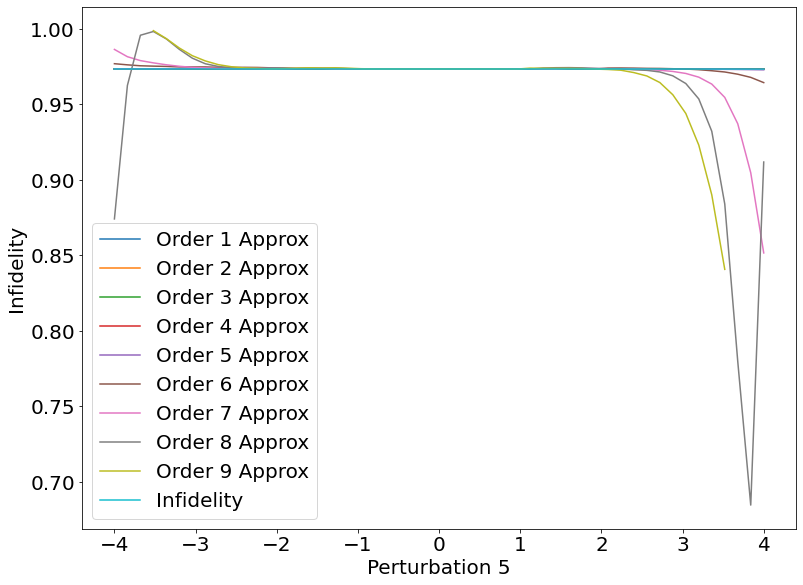

In [18]:
perturb5_vals = jnp.linspace(-4., 4., 51)

perturb5_results = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([0., 0., 0., 0., 1., 0.]), 
    perturbation = lambda t: -1j * perturb5, 
    perturb_vals=perturb5_vals,
    max_magnus_order=max_magnus_order
)

for k in range(max_magnus_order):
    plt.plot(perturb5_vals, perturb5_results[1][k],label=f'Order {k+1} Approx')

plt.plot(perturb5_vals, perturb5_results[0], label='Infidelity')
plt.legend()
plt.xlabel('Perturbation 5')
plt.ylabel('Infidelity')

Text(0, 0.5, 'Infidelity error')

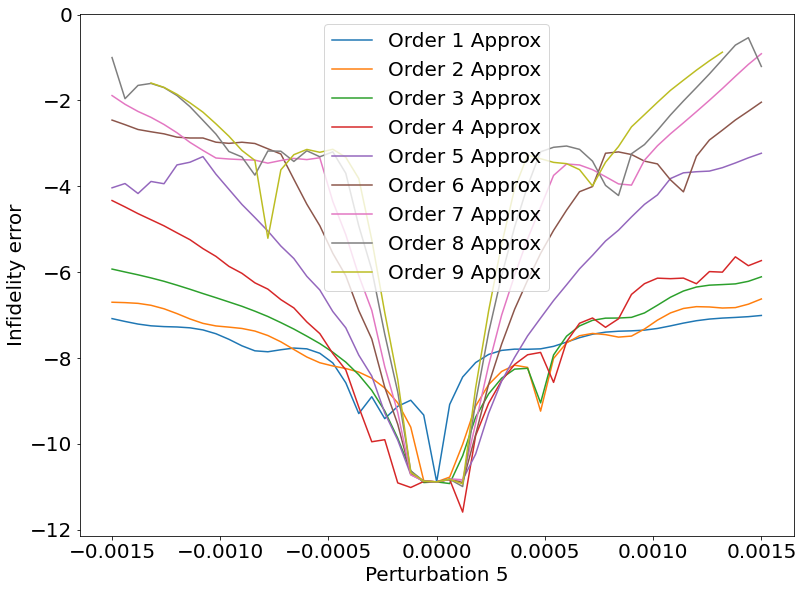

In [19]:
# error plot
errors5 = [
    np.log10(np.abs(np.array(perturb5_results[1][k]) - np.array(perturb5_results[0]))) for k in range(max_magnus_order)
]

for k in range(max_magnus_order):
    plt.plot(perturb1_vals,errors5[k],label=f'Order {k+1} Approx')

plt.legend()
plt.xlabel('Perturbation 5')
plt.ylabel('Infidelity error')

## 4.6 6th perturbation

This is one of the nicest looking ones.

Text(0, 0.5, 'Infidelity')

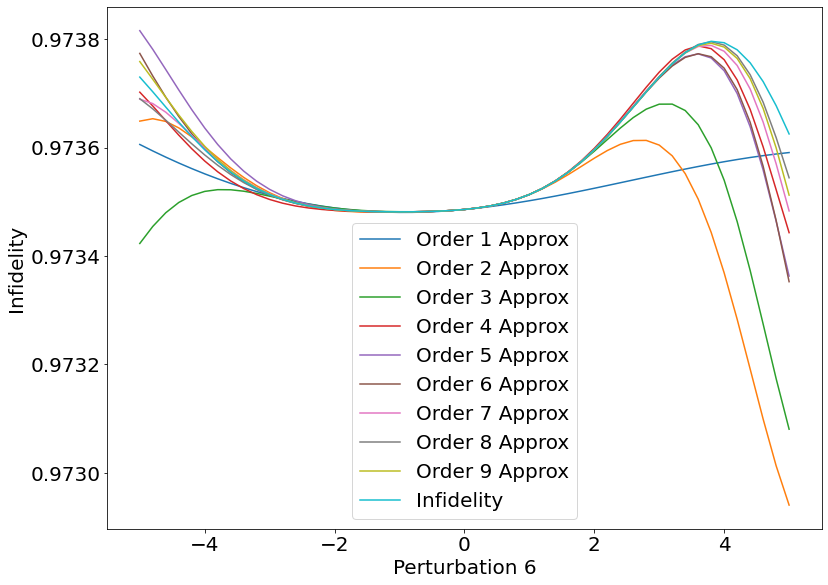

In [20]:
perturb6_vals = jnp.linspace(-5.0, 5.0, 51)

# compute perturbation terms
samples = param_to_signal(rand_control_params)
control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)

perturb6_results = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([0., 0., 0., 0., 0., 1.]), 
    perturbation = lambda t: -1j * control_signal(t) * perturb6, 
    perturb_vals=perturb6_vals,
    max_magnus_order=max_magnus_order
)

for k in range(max_magnus_order):
    plt.plot(perturb6_vals, perturb6_results[1][k],label=f'Order {k+1} Approx')

plt.plot(perturb6_vals, perturb6_results[0], label='Infidelity')
plt.legend()
plt.xlabel('Perturbation 6')
plt.ylabel('Infidelity')

Text(0, 0.5, 'Infidelity error')

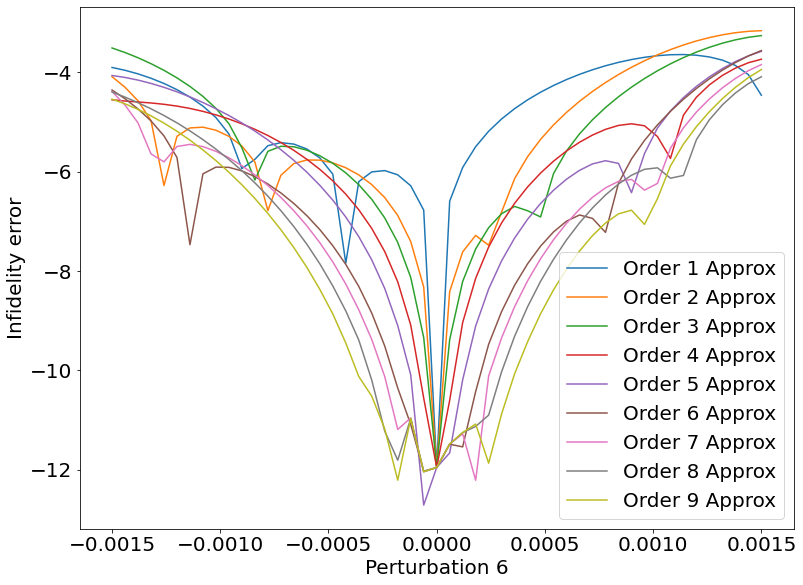

In [21]:
# error plot
errors6 = [
    np.log10(np.abs(np.array(perturb6_results[1][k]) - np.array(perturb6_results[0]))) for k in range(max_magnus_order)
]

for k in range(max_magnus_order):
    plt.plot(perturb1_vals,errors6[k],label=f'Order {k+1} Approx')

plt.legend()
plt.xlabel('Perturbation 6')
plt.ylabel('Infidelity error')

## 4.7 2D plot

In [22]:
def compute_2d_perturbation_comparison(
    control_params, 
    model_params_dirs,
    perturbations,
    perturb_vals,
    max_magnus_order=5
):
    """
    Args:
        control_params for params to signal
        model_params_dir for 1d direction in model parameter space
        perturbation is the function computing the perturbation in the lab frame
        perturb_vals is the list of values to plot over
        max_magnus_order is the maximum magnus order to compute up to
    """
    (model_params_dir1, model_params_dir2) = model_params_dirs
    (perturbation1,perturbation2) = perturbations
    (perturb_vals1, perturb_vals2) = perturb_vals
    # jit function for computing ode fidelity
    ode_func = jit(lambda x,y: ode_infidelity(control_params, x * model_params_dir1 + y * model_params_dir2))
    
    # compute perturbation terms
    samples = param_to_signal(control_params)
    control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
    
    def generator(t):
        op = control_signal(t) * (-1j * drive_hamiltonian)
        return rotating_frame.operator_into_frame(t, op)
    
    def perturb_in_frame1(t):
        op = perturbation1(t)
        return rotating_frame.operator_into_frame(t, op)
    
    def perturb_in_frame2(t):
        op = perturbation2(t)
        return rotating_frame.operator_into_frame(t, op)
    
    # change tolerance here
    results = solve_lmde_perturbation(
        perturbations=[perturb_in_frame1, perturb_in_frame2],
        t_span=[0, T],
        expansion_method='magnus',
        expansion_order=max_magnus_order,
        generator=generator,
        integration_method='jax_odeint',
        rtol=1e-14,
        atol=1e-14
    )
    term_labels = results.perturbation_data.labels
    perturbation_terms = results.perturbation_data.data
    
    # construct magnus expansions for each order from results
    magnus_expansions = []
    for order in range(1, max_magnus_order + 1):
        n_terms = list(map(lambda x: len(x) <= order, term_labels)).count(True)
        magnus_expansion = ArrayPolynomial(
            array_coefficients=perturbation_terms[:n_terms, -1],
            monomial_labels=term_labels[:n_terms]
        )
        magnus_expansions.append(magnus_expansion)
    
    U = results.y[-1]

    # get the approximate error rates using the Magnus terms
    @partial(jit, static_argnums=(2,))
    def err_est(c1, c2, order):

        coeffs = jnp.array([c1, c2])

        U_approx = U @ jexpm(magnus_expansions[order - 1](coeffs).data)

        return 1. - fidelity(U_approx).data
    
    ode_vals = []
    magnus_vals = [[] for _ in range(max_magnus_order)]
    for val1 in perturb_vals1:
        for val2 in perturb_vals2:
            ode_vals.append(ode_func(val1,val2))
        
            for order, magnus_val in enumerate(magnus_vals):
                magnus_val.append(err_est(val1, val2, order + 1))
    
    return ode_vals, magnus_vals

In [23]:
max_magnus_order = 9
# use perturbation 1 and 3
perturb2d_results = compute_2d_perturbation_comparison(
    rand_control_params,
    (jnp.array([1., 0., 0., 0., 0., 0.]),jnp.array([0., 0., 1., 0., 0., 0.])),
    (lambda t: -1j * perturb1, lambda t: -1j * control_signal(t) * drive_hamiltonian), 
    perturb_vals= (perturb1_vals, perturb3_vals),
    max_magnus_order=max_magnus_order
)

In [24]:
# helper function for 2D meshplots
def cell_centered(arr_in):
    arr_out = np.empty(len(arr_in)+1)
    dist = arr_in[1] - arr_in[0]
    for i in range(len(arr_in)):
        arr_out[i] = arr_in[i] - dist/2
    arr_out[-1] = arr_in[-1] + dist/2
    return arr_out

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

#plot the differences between estimates and exact error
diffs = []
for k in range(max_magnus_order):
    diffs.append(jnp.array(perturb2d_results[1][k]) - jnp.array(perturb2d_results[0]))

x_cell = cell_centered(perturb3_vals)
y_cell = cell_centered(perturb1_vals)

# need to determine colorbar range here

diff_min = min(min(diff) for diff in diffs)
diff_max = max(max(diff) for diff in diffs)
cb_max = max(abs(diff_min), abs(diff_max))
cb_min = -1 * cb_max

lt = 1e-6
ls = 1.

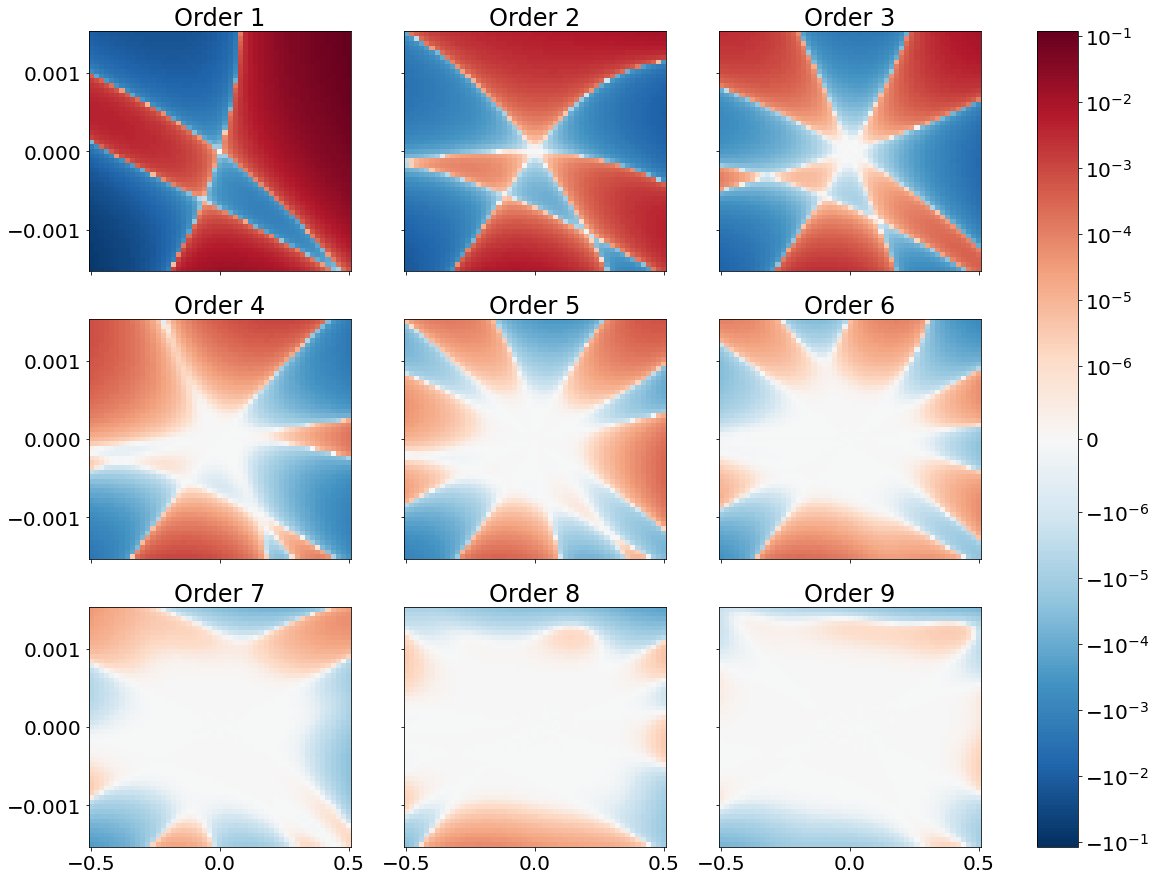

In [25]:
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
#plt.rcParams.update({'font.size': 20})

# plot in single grid
fig, axes = plt.subplots(nrows=3, ncols=3, sharex='col', sharey='row', figsize=(20, 15))
images = []
for row_idx, axis_row in enumerate(axes):
    image_row=[]
    for col_idx, ax in enumerate(axis_row):
        k = 3 * row_idx + col_idx
        
        im = ax.pcolormesh(
                x_cell, y_cell, diffs[k].reshape(len(perturb1_vals),len(perturb3_vals)),
                norm=colors.SymLogNorm(linthresh=lt, linscale=ls,vmin=cb_min, vmax=cb_max),
                cmap='RdBu_r'
            )
        image_row.append(im)
        ax.title.set_text(f'Order {k+1}')
    
    images.append(image_row)

fig.colorbar(images[-1][-1], ax=axes.ravel().tolist())
#plt.colorbar(images[5], ax=axes[5])

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#fig.set_size_inches(6, 18.5*2.) #change these numbers to adjust the plots
plt.show()

# 5. Robustness objective

Next, we construct a robustness objective to various orders in the Magnus expansion and incorporating some number of the above perturbations. For a given truncated expansion $\Omega(c)$, up to some order and for some number of perturbations, we construct an objective as:

$$\int_D dc p(c) \left\|\Omega(c)Q - \frac{Tr(\Omega(c)Q)}{2}Q \right\|_2^2,$$

where $Q$ is the projection onto the computational subspace, and $D$ is the domain of integration with $p$ a heuristically chosen probability distribution. For reasonably chosen $D$ and $p$, this objective has the property that $g = 0$ implies that, to the order of truncation of $\Omega(c)$, the perturbations have no impact on the final unitary.

Here we choose $p$ to be a product distribution, and construct the above objective utilizing `solve_lmde_perturbation` to compute the truncated Magnus expansion, along with the `ArrayPolynomial` class to manipulate and transform it to compute the objective.

For different truncation orders, we plot the time it takes to evaluate the objective, along with its gradients with respect to control parameters, as a function of the number of perturbations.

In [26]:
from scipy.integrate import quad

In [28]:
from multiset import Multiset
from qiskit_dynamics.perturbation.perturbation_utils import _merge_multiset_expansion_order_labels
from qiskit_dynamics.perturbation.multiset_utils import _get_all_submultisets

def polynomial_integrate(f, a, b, degree):
    """Integrate [f(x), x*f(x), ..., (x**degree) * f(x)] over [a, b]."""
    
    results = []
    for k in range(degree + 1):
        integrand = lambda t: (t**k) * f(t)
        results.append(quad(integrand, a, b)[0])
    
    return np.array(results)

def independent_multivariable_integrate(f_list, ranges, max_degree):
    """Return an array of shape (degrees[0] + 1, ..., degrees[-1] + 1),
    whose i[0], ..., i[-1] entry is the integral
    
    (degrees)
    """
    
    one_d_results = []
    for f, [a, b] in zip(f_list, ranges):
        one_d_results.append(polynomial_integrate(f, a, b, max_degree)) 
    
    # construct all multisets up to a given degree
    multisets = _merge_multiset_expansion_order_labels(
        perturbation_labels=[[k] for k in range(len(f_list))],
        expansion_order=max_degree
    )
    multisets = _get_all_submultisets(multisets)
    
    # prepend the empty multiset
    multisets = [Multiset({})] + multisets

    integration_results = []
    for multiset in multisets:
        res = 1.
        for k in range(len(f_list)):
            res = res * one_d_results[k][multiset[k]]
        
        integration_results.append(res)
    
    return np.array(integration_results), multisets

def get_guassian(mean, std):
    
    const = 1 / (std * np.sqrt(2 * np.pi))
    
    return lambda t: const * np.exp(-0.5 * ((t - mean) / std)**2)

Chosen distributions for each parameter.

In [29]:
##########################################
# magnus order and number of perturbations
##########################################

integration_ranges = [
    [-0.002, 0.002], # frequency
    [-0.1, 0.1], # anharmonicity
    [-1., 1.], # drive strength
    [-1., 1.], # non-linear control term
    [-0.5, 0.5], # higher level spacings
    [-2., 2.] # higher level drive operator
]

means = np.zeros(6, dtype=float)
stds = np.ones(6, dtype=float)

rotating_frame = solver.model.rotating_frame


def construct_magnus_objective(magnus_order, n_perturb):
    """Construct the magnus objective function given an expansion order
    and number of perturbations.
    """


    ##############################
    # compute distribution moments
    ##############################


    f_list = [get_guassian(mean, std) for mean, std in zip(means[:n_perturb], stds[:n_perturb])]

    moments, multisets = independent_multivariable_integrate(
        f_list, 
        ranges=integration_ranges, 
        max_degree=2 * magnus_order
    )

    # normalize in case distribution is cut off
    moments = moments / moments[0]

    ############################################################
    # determine elements to cut based on the integral being zero
    ############################################################
    
    tol=1e-12

    nonzero_idx = []
    nonzero_moments = []
    nonzero_multisets = []
    for idx, (moment, multiset) in enumerate(zip(moments, multisets)):
        if np.abs(moment) > tol:
            nonzero_idx.append(idx)
            nonzero_moments.append(moment)
            nonzero_multisets.append(multiset)

    nonzero_idx = np.array(nonzero_idx)
    nonzero_moments = np.array(nonzero_moments)

    # build function using the above moments
    
    def magnus_computation(params):

        ##############################
        # setup time-dependent signals
        ##############################

        samples = param_to_signal(params)
        control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
        control_signal2 = control_signal * control_signal

        def generator(t):
            op = control_signal(t) * (-1j * drive_hamiltonian)
            return rotating_frame.operator_into_frame(t, op)

        def perturbation1(t):
            op = -1j * perturb1
            return rotating_frame.operator_into_frame(t, op)

        def perturbation2(t):
            op = -1j * perturb2
            return rotating_frame.operator_into_frame(t, op)

        def perturbation3(t):
            op = -1j * control_signal(t) * drive_hamiltonian
            return rotating_frame.operator_into_frame(t, op)

        def perturbation4(t):
            op = -1j * control_signal2(t) * drive_hamiltonian
            return rotating_frame.operator_into_frame(t, op)

        def perturbation5(t):
            op = -1j * perturb5
            return rotating_frame.operator_into_frame(t, op)

        def perturbation6(t):
            op = -1j * control_signal(t) * perturb6
            return rotating_frame.operator_into_frame(t, op)


        perturbations = [
            perturbation1,
            perturbation2,
            perturbation3,
            perturbation4,
            perturbation5,
            perturbation6,
        ]

        perturbations = perturbations[:n_perturb]

        results = solve_lmde_perturbation(
            perturbations=perturbations,
            t_span=jnp.array([0., T]),
            expansion_method='magnus',
            expansion_order=magnus_order,
            generator=generator,
            integration_method='jax_odeint',
            rtol=1e-10,
            atol=1e-10
        )

        # final unitary
        U = results.y[-1]

        ################################
        # construct robustness objective
        ################################
        
        # construct polynomial object
        magnus_terms = results.perturbation_data.data[:, -1]
        monomial_labels = results.perturbation_data.labels

        magnus_polynomial = ArrayPolynomial(
            array_coefficients=magnus_terms,
            monomial_labels=monomial_labels
        )

        # project onto computational subspace
        magnus_polynomial = magnus_polynomial[0:2, 0:2]

        # remove identity component
        magnus_no_id = (
            magnus_polynomial - (magnus_polynomial.trace() * (np.eye(2, dtype=complex) / 2))
        )

        # construct polynomial for norm, only including nonzero moments
        magnus_norm = magnus_no_id.conj().mul(
            magnus_no_id, monomial_filter=lambda x: x in nonzero_multisets
        ).real.sum()
        
        # final integral is a linear combination of the polynomial coefficients
        robustness_integral = np.dot(magnus_norm.array_coefficients, nonzero_moments[1:]).data

        ##################################
        # fidelity objective
        ##################################

        fid = fidelity(U).data

        #############################
        # return linearized objective
        #############################
        return (1 - fid) + 0.001 * robustness_integral / T

    return magnus_computation

## 5.1 Scaling in perturbation at order 1

In [30]:
rand_control_params = 10. * np.random.rand(2, cheb_order + 1)

In [31]:
from time import time
from jax import value_and_grad

In [32]:
magnus1_objectives = []
magnus1_objective_grads = []
for k in range(1, 7):
    magnus1_objectives.append(jit(construct_magnus_objective(magnus_order=1, n_perturb=k)))
    magnus1_objective_grads.append(jit(value_and_grad(construct_magnus_objective(magnus_order=1, n_perturb=k))))

magnus1_objectives_speed_pre_compiled = []
magnus1_objectives_speed = []
magnus1_grad_speed_pre_compiled = []
magnus1_grad_speed = []

for obj, grad_obj in zip(magnus1_objectives, magnus1_objective_grads):
    start = time()
    res = obj(rand_control_params).block_until_ready()
    magnus1_objectives_speed_pre_compiled.append(time() - start)
    
    start = time()
    res = obj(rand_control_params).block_until_ready()
    magnus1_objectives_speed.append(time() - start)
    
    start = time()
    res = grad_obj(rand_control_params)[0].block_until_ready()
    magnus1_grad_speed_pre_compiled.append(time() - start)
    
    start = time()
    res = grad_obj(rand_control_params)[0].block_until_ready()
    magnus1_grad_speed.append(time() - start)

In [33]:
print('compile + simulate: ' + str(magnus1_objectives_speed_pre_compiled))
print('compiled time: ' + str(magnus1_objectives_speed))
print('grad + compile + simulate: ' + str(magnus1_grad_speed_pre_compiled))
print('grad compiled time: ' + str(magnus1_grad_speed))

compile + simulate: [1.9579908847808838, 2.552867889404297, 3.256639003753662, 3.291722059249878, 4.2407450675964355, 4.246263027191162]
compiled time: [0.41744303703308105, 0.6982729434967041, 1.013063907623291, 1.2092359066009521, 1.5323426723480225, 1.781738042831421]
grad + compile + simulate: [8.445362329483032, 11.008058786392212, 13.412089824676514, 18.917870044708252, 22.583534002304077, 27.412028074264526]
grad compiled time: [3.8639957904815674, 5.527544021606445, 6.761465072631836, 11.578179121017456, 14.501761198043823, 17.98250913619995]


In [34]:
magnus2_objectives = []
magnus2_objective_grads = []
for k in range(1, 7):
    magnus2_objectives.append(jit(construct_magnus_objective(magnus_order=2, n_perturb=k)))
    magnus2_objective_grads.append(jit(value_and_grad(construct_magnus_objective(magnus_order=2, n_perturb=k))))

magnus2_objectives_speed_pre_compiled = []
magnus2_objectives_speed = []
magnus2_grad_speed_pre_compiled = []
magnus2_grad_speed = []

for obj, grad_obj in zip(magnus2_objectives, magnus2_objective_grads):
    start = time()
    res = obj(rand_control_params).block_until_ready()
    magnus2_objectives_speed_pre_compiled.append(time() - start)
    
    start = time()
    res = obj(rand_control_params).block_until_ready()
    magnus2_objectives_speed.append(time() - start)
    
    start = time()
    res = grad_obj(rand_control_params)[0].block_until_ready()
    magnus2_grad_speed_pre_compiled.append(time() - start)
    
    start = time()
    res = grad_obj(rand_control_params)[0].block_until_ready()
    magnus2_grad_speed.append(time() - start)

In [35]:
print('compile + simulate: ' + str(magnus2_objectives_speed_pre_compiled))
print('compiled time: ' + str(magnus2_objectives_speed))
print('grad + compile + simulate: ' + str(magnus2_grad_speed_pre_compiled))
print('grad compiled time: ' + str(magnus2_grad_speed))

compile + simulate: [2.666667938232422, 3.6123838424682617, 5.464514970779419, 8.603380918502808, 11.563682079315186, 14.398497104644775]
compiled time: [0.7654411792755127, 1.666538953781128, 3.084131956100464, 5.77741003036499, 8.283097982406616, 10.948482751846313]
grad + compile + simulate: [10.272160768508911, 15.807752847671509, 22.350667238235474, 37.302053689956665, 48.67776608467102, 61.30682110786438]
grad compiled time: [4.705159902572632, 8.90851902961731, 14.863116025924683, 28.708539962768555, 38.73073697090149, 51.95155382156372]


In [36]:
magnus3_objectives = []
magnus3_objective_grads = []
for k in range(1, 7):
    magnus3_objectives.append(jit(construct_magnus_objective(magnus_order=3, n_perturb=k)))
    magnus3_objective_grads.append(jit(value_and_grad(construct_magnus_objective(magnus_order=3, n_perturb=k))))

magnus3_objectives_speed_pre_compiled = []
magnus3_objectives_speed = []
magnus3_grad_speed_pre_compiled = []
magnus3_grad_speed = []

for obj, grad_obj in zip(magnus3_objectives, magnus3_objective_grads):
    start = time()
    res = obj(rand_control_params).block_until_ready()
    magnus3_objectives_speed_pre_compiled.append(time() - start)
    
    start = time()
    res = obj(rand_control_params).block_until_ready()
    magnus3_objectives_speed.append(time() - start)
    
    start = time()
    res = grad_obj(rand_control_params)[0].block_until_ready()
    magnus3_grad_speed_pre_compiled.append(time() - start)
    
    start = time()
    res = grad_obj(rand_control_params)[0].block_until_ready()
    magnus3_grad_speed.append(time() - start)

In [37]:
print('compile + simulate: ' + str(magnus3_objectives_speed_pre_compiled))
print('compiled time: ' + str(magnus3_objectives_speed))
print('grad + compile + simulate: ' + str(magnus3_grad_speed_pre_compiled))
print('grad compiled time: ' + str(magnus3_grad_speed))

compile + simulate: [3.6195340156555176, 5.36600399017334, 10.068060159683228, 20.40896201133728, 33.99154591560364, 47.66896367073059]
compiled time: [1.062284231185913, 3.416456937789917, 7.546825885772705, 18.26605796813965, 30.51605486869812, 44.05000281333923]
grad + compile + simulate: [11.956820964813232, 21.25563907623291, 38.928303718566895, 80.31185913085938, 129.0060999393463, 185.65542197227478]
grad compiled time: [6.009385108947754, 15.096143245697021, 29.87702488899231, 70.98155999183655, 116.50554299354553, 176.93386912345886]


In [38]:
magnus4_objectives = []
magnus4_objective_grads = []
for k in range(1, 7):
    magnus4_objectives.append(jit(construct_magnus_objective(magnus_order=4, n_perturb=k)))
    magnus4_objective_grads.append(jit(value_and_grad(construct_magnus_objective(magnus_order=4, n_perturb=k))))

magnus4_objectives_speed_pre_compiled = []
magnus4_objectives_speed = []
magnus4_grad_speed_pre_compiled = []
magnus4_grad_speed = []

for obj, grad_obj in zip(magnus4_objectives, magnus4_objective_grads):
    start = time()
    res = obj(rand_control_params).block_until_ready()
    magnus4_objectives_speed_pre_compiled.append(time() - start)
    
    start = time()
    res = obj(rand_control_params).block_until_ready()
    magnus4_objectives_speed.append(time() - start)
    
    start = time()
    res = grad_obj(rand_control_params)[0].block_until_ready()
    magnus4_grad_speed_pre_compiled.append(time() - start)
    
    start = time()
    res = grad_obj(rand_control_params)[0].block_until_ready()
    magnus4_grad_speed.append(time() - start)

In [39]:
print('compile + simulate: ' + str(magnus4_objectives_speed_pre_compiled))
print('compiled time: ' + str(magnus4_objectives_speed))
print('grad + compile + simulate: ' + str(magnus4_grad_speed_pre_compiled))
print('grad compiled time: ' + str(magnus4_grad_speed))

compile + simulate: [3.3061742782592773, 8.393627882003784, 16.69351601600647, 44.935858964920044, 83.75932693481445, 147.45741605758667]
compiled time: [1.489631175994873, 5.527293920516968, 13.907100200653076, 42.31510090827942, 79.9516270160675, 140.72476816177368]
grad + compile + simulate: [13.107892990112305, 29.35982918739319, 60.87420582771301, 168.05105900764465, 313.95869493484497, 506.12410497665405]
grad compiled time: [7.121539115905762, 23.395879983901978, 55.192089796066284, 156.33160495758057, 305.12552404403687, 590.9321269989014]


In [ ]:
magnus5_objectives = []
magnus5_objective_grads = []
for k in range(1, 7):
    magnus5_objectives.append(jit(construct_magnus_objective(magnus_order=5, n_perturb=k)))
    magnus5_objective_grads.append(jit(value_and_grad(construct_magnus_objective(magnus_order=5, n_perturb=k))))

magnus5_objectives_speed_pre_compiled = []
magnus5_objectives_speed = []
magnus5_grad_speed_pre_compiled = []
magnus5_grad_speed = []

for obj, grad_obj in zip(magnus5_objectives, magnus5_objective_grads):
    start = time()
    res = obj(rand_control_params).block_until_ready()
    magnus5_objectives_speed_pre_compiled.append(time() - start)
    
    start = time()
    res = obj(rand_control_params).block_until_ready()
    magnus5_objectives_speed.append(time() - start)
    
    start = time()
    res = grad_obj(rand_control_params)[0].block_until_ready()
    magnus5_grad_speed_pre_compiled.append(time() - start)
    
    start = time()
    res = grad_obj(rand_control_params)[0].block_until_ready()
    magnus5_grad_speed.append(time() - start)

In [ ]:
print('compile + simulate: ' + str(magnus5_objectives_speed_pre_compiled))
print('compiled time: ' + str(magnus5_objectives_speed))
print('grad + compile + simulate: ' + str(magnus5_grad_speed_pre_compiled))
print('grad compiled time: ' + str(magnus5_grad_speed))

In [ ]:
# plot compile + sim time
perturb_nums = [1, 2, 3, 4, 5, 6]

plt.plot(perturb_nums, magnus1_objectives_speed_pre_compiled, label='1st order Magnus')
plt.plot(perturb_nums, magnus2_objectives_speed_pre_compiled, label='2nd order Magnus')
plt.plot(perturb_nums, magnus3_objectives_speed_pre_compiled, label='3rd order Magnus')
plt.plot(perturb_nums, magnus4_objectives_speed_pre_compiled, label='4th order Magnus')
plt.plot(perturb_nums, magnus5_objectives_speed_pre_compiled, label='5th order Magnus')
plt.legend()
plt.xlabel('Number of perturbations')
plt.ylabel('Time (s)')
plt.title('Compilation + simulation time')

In [ ]:
# compiled simulation time

plt.plot(perturb_nums, magnus1_objectives_speed, label='1st order Magnus')
plt.plot(perturb_nums, magnus2_objectives_speed, label='2nd order Magnus')
plt.plot(perturb_nums, magnus3_objectives_speed, label='3rd order Magnus')
plt.plot(perturb_nums, magnus4_objectives_speed, label='4th order Magnus')
plt.plot(perturb_nums, magnus5_objectives_speed, label='5th order Magnus')
plt.legend()
plt.xlabel('Number of perturbations')
plt.ylabel('Time (s)')
plt.title('Compiled simulation time')

In [ ]:
# gradient compilation + simulation time

plt.plot(perturb_nums, magnus1_grad_speed_pre_compiled, label='1st order Magnus')
plt.plot(perturb_nums, magnus2_grad_speed_pre_compiled, label='2nd order Magnus')
plt.plot(perturb_nums, magnus3_grad_speed_pre_compiled, label='3rd order Magnus')
plt.plot(perturb_nums, magnus4_grad_speed_pre_compiled, label='4th order Magnus')
plt.plot(perturb_nums, magnus5_grad_speed_pre_compiled, label='5th order Magnus')
plt.legend()
plt.xlabel('Number of perturbations')
plt.ylabel('Time (s)')
plt.title('Gradient + compile + simulation time')

In [ ]:
# compiled gradient simulation time

plt.plot(perturb_nums, magnus1_grad_speed, label='1st order Magnus')
plt.plot(perturb_nums, magnus2_grad_speed, label='2nd order Magnus')
plt.plot(perturb_nums, magnus3_grad_speed, label='3rd order Magnus')
plt.plot(perturb_nums, magnus4_grad_speed, label='4th order Magnus')
plt.plot(perturb_nums, magnus5_grad_speed, label='5th order Magnus')
plt.legend()
plt.xlabel('Number of perturbations')
plt.ylabel('Time (s)')
plt.title('Compiled gradient simulation time')